In [237]:
# Importing libraries

import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import yaml
from git_root import git_root
from transformers import AutoTokenizer

In [238]:
# adding git_root and local imports
my_git_root = git_root()
sys.path.append(my_git_root)

from src import flatten, contains_text, extract_table

In [272]:
# importing data
df_documents_path = f'{my_git_root}/data/documents_cleaned.csv'
df_documents = pd.read_csv(df_documents_path)

In [240]:
# importing settings
with open(f'{my_git_root}/settings.yaml', 'r') as file:
    settings = yaml.safe_load(file)

print(settings)

sentence_transformer_model_name = settings['sentence_transformer_model_name']
sentence_transformer_max_tokens = settings['sentence_transformer_max_tokens']

{'sentence_transformer_model_name': 'thenlper/gte-small', 'sentence_transformer_max_tokens': 512, 'llm_model_name': 'tiiuae/Falcon3-7B-Instruct'}


In [241]:
# initializing tokenizer
tokenizer = AutoTokenizer.from_pretrained(sentence_transformer_model_name)

In [242]:
df_documents

,name,text
0,aalto-university.md,# Aalto University \n\n## Aalto University Re...
1,aberystwyth-university.md,# Research Data Management Policy \n\nVersion...
2,aston-university.md,# Research Data Management Policy \n\nJuly 20...
3,bangor-university.md,# Data Protection Policy \n\n Rev Date Purpos...
4,brunel-university-london.md,# Brunel University Research Data Management P...
...,...,...
137,universität-rostock.md,# Research Data Policy of the University of Ro...
138,universität-siegen.md,# Research-Data-Policy of the University of Si...
139,universität-stuttgart.md,# Research data management policy of the Unive...
140,utrecht-university.md,# University policy framework for research dat...


In [243]:
document_names = df_documents['name'].to_list()
documents = df_documents['text'].to_list()

In [244]:
def check_documents_for_chunks(df, text_col, regex_pattern):
    doc_chunk_lengths = []
    doc_chunked_successfully = []
    for index, row in df.iterrows():
        text_chunked = re.split(regex_pattern, row[text_col])
        text_chunked = [text for text in text_chunked if len(text) > 0]
        doc_chunk_lengths.append([len(chunk) for chunk in text_chunked])
        if len(text_chunked) > 1:
            doc_chunked_successfully.append(True)
        else:
            doc_chunked_successfully.append(False)
    return doc_chunked_successfully, doc_chunk_lengths

In [245]:
def get_delimiter_stats(df, text_col, delimiters):

    chunk_lengths = []
    delimiter_type = delimiters.keys()
    delimiters_successful = []
    delimiters_successful_percentage = []
    median_split_lens = []

    for key, value in delimiters.items():
        doc_chunked_successfully, doc_chunk_lengths = check_documents_for_chunks(df, text_col, value)
        delimiters_successful.append(np.sum(doc_chunked_successfully))
        delimiters_successful_percentage.append(np.sum(doc_chunked_successfully) / len(doc_chunked_successfully))
        median_split_lens.append(np.median(flatten(doc_chunk_lengths)))
        chunk_lengths.append(flatten(doc_chunk_lengths))

    df_delimiter_stats = pd.DataFrame(data={
        'delimiter_type': delimiter_type,
        'delimiter_successful': delimiters_successful,
        'delimiter_successful_percentage': delimiters_successful_percentage,
        'median_split_len': median_split_lens
    })

    return df_delimiter_stats, chunk_lengths

In [264]:
def get_delimiters(level):
    delimiters = {
        'headings': rf'\s*#{{{level}}}\s*',
        'list_items': rf'\n\s*#*\s*\d+\.(\d+\.?){{{level}}}\s+',
        'list': r'\d+\.\s*(?!\d+\.?)*\s*',
        'newline': r'\n',
        'paragraph': r'\s*\n\s*\n\s*',
    }

    return delimiters

def chunk_document(document):
    result = []

    for level in range(0, 4):
        document_chunked = chunk_by_least_common_delimiter(document, get_delimiters(level))
        if document_chunked is not None:
            for chunk in document_chunked:
                chunk_num_tokens = len(tokenizer.tokenize(chunk))
                if chunk_num_tokens < sentence_transformer_max_tokens:
                    result.append(chunk)
                else:
                    result.append(chunk_document(chunk))
    return result

In [266]:
chunk_by_least_common_delimiter(documents[1], get_delimiters(0))

paragraph


['# Research Data Management Policy',
 'Version 3.0',
 'Policy Title ResearchDataManagementPolicy \nApproval Date 18 February 2020 \nApproving Body ResearchCommittee \nVersion 3.0 \nSupersedes 2.2 \nPreviousreviewdate June 2021 \nNextreviewdate Autumn 2022 \nPolicy Owner Pro Vice-Chancellor - Research, Knowledge Exchange, and Innovation \nLead contact Open Access and Research Data Officer',
 'This policy defines the responsibilities at individual and institutional level which should guide the work of those involved in data collection, processing, storage, maintenance, and archival.',
 '1. Research data will be managed to the highest standards throughout the research data lifecycle as part of the University’s commitment to research excellence.   \n2. Responsibility for research data management during any research project or programme lies primarily with Principal Investigators (PIs).   \n3. All new research proposals must include a Data Management Plan (DMP) that explicitly addresses da

In [260]:
documents_chunked = [chunk_document(document) for document in documents]

In [252]:
documents_chunked[0]

[['# Aalto University',
  '## Aalto University Research Data Management Policy',
  'The research data management policy aims to make data management easier for the individual researcher. Managing and curating data creates competitive edge, and allocating resources for that is a strategic choice of the university. The purposes of this policy are to (1) encourage to informed decision making in research data management and (2) define the principles used in the opening of publicly funded scientific research data to achieve wide societal impact and the strategic goals of Aalto University.',
  'The data management policy shall be implemented through conscious and strategic decisions. Open access publishing of research data aims to make research data easily discoverable, assessable, intelligible, usable and interoperable. Where applicable, these requirements can also be applied to data other than open access published research data, and to the software needed to handle the open data. The deci

In [248]:
for text in documents:
    matches = re.findall(r'\n\s*#*\s*\d+\.(\d+\.?){5}\s+', text)
    if len(matches) != 0:
        print(matches)
        print(text)
        print('-'*100)

['0', '1', '1']
# Policy Framework for Research Data Management (RDM)  

Max-Delbruck-Centrum fur Molekulare Medizin in der Helmholtz-Gemeinschaft  

 Version 2.0 
Dateofversion: 01.03.2021 
Reviewer: SaraEl-Gebali 
Frequencyofreviews: Annually 
Created by: Julia Haseleu 
Participatingdepartmentsandcommittees: RDM,IT,DPO 
Approved by: MDCBoardofDirectors 
Status: Valid 
Confidentialitylevel: Public 
  

## Change History  

 Date Version Createdby Descriptionofchanges 
21.10.2020 1.0 JuliaHaseleu Firstversion approvedbyMDC-Board 
20.01.2021 2.0 SaraEl-Gebali CommentsfromITaddressed,IPRsection reviewed 
01.03.2021 2.0 SaraEl-Gebali ApprovedbyMDC-Board 
  

## Content  

### Preamble.. 3  

1. Jurisdiction. 3   
2. Intellectual property rights. 3   
3. Handling research data. 4   
Data storage. 4   
Data access and re-use . 4   
Deletion of data. 5   
4. Responsibilities,rights,duties 5   
Principal Investigators and Researchers are responsible for 5   
The MDC is responsible for. 6   
5

In [274]:
delimiters = {
    'headings_level_1': r'\s*#{1}\s*',
    'headings_level_2': r'\s*#{2}\s*',
    'headings_level_3': r'\s*#{3}\s*',
    'headings_level_4': r'\s*#{4}\s*',
    'list_level_1': r'\n\s*#*\s*\d+\.(\d+\.?){0}\s+',
    'list_level_2': r'\n\s*#*\s*\d+\.(\d+\.?){1}\s+',
    'list_level_3': r'\n\s*#*\s*\d+\.(\d+\.?){2}\s+',
    'list_level_4': r'\n\s*#*\s*\d+\.(\d+\.?){3}\s+',
    'list_level_5': r'\n\s*#*\s*\d+\.(\d+\.?){4}\s+',
    'newline': r'\n',
    'paragraph': r'\s*\n\s*\n\s*',
}

In [276]:
df_delimiter_stats, chunk_lengths = get_delimiter_stats(df_documents, 'text', delimiters)
df_delimiter_stats

TypeError: object of type 'NoneType' has no len()

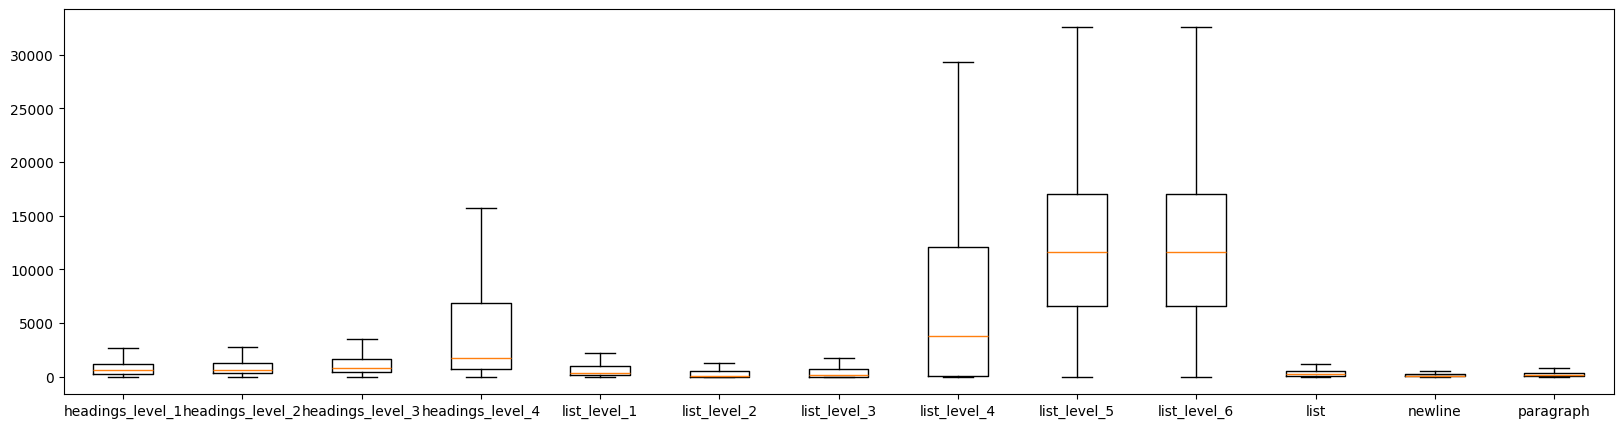

In [269]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.boxplot(chunk_lengths, showfliers=False)
ax.set_xticklabels(delimiters.keys())

plt.show()

In [125]:
def count_headings(document):
    matches = re.findall(r'#+', document)
    if matches == None:
        return 0
    return len(matches)

In [192]:
headings_count = [count_headings(document) for document in documents]

In [193]:
np.argmin(headings_count)

np.int64(95)

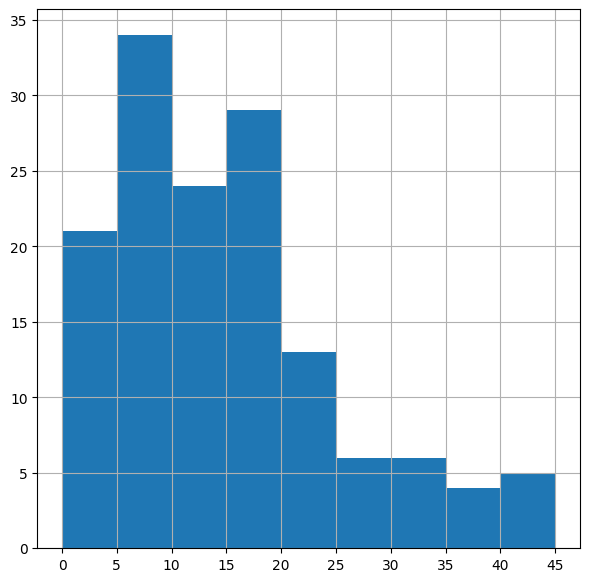

In [194]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.hist(headings_count, bins=np.arange(0, np.max(headings_count) + 5, 5))
ax.grid()
ax.set_xticks(np.arange(0, np.max(headings_count) + 5, 5))
plt.show()

In [207]:
def count_numbered_lists(document):
    matches = re.findall(r'\n\s*#*\s*\d+\.(\d+\.?)?\s+', document)
    if matches == None:
        return 0
    return len(matches)

In [208]:
list_count = [count_numbered_lists(document) for document in documents]

In [209]:
np.argmin(list_count)

np.int64(7)

In [210]:
list_count[17]

0

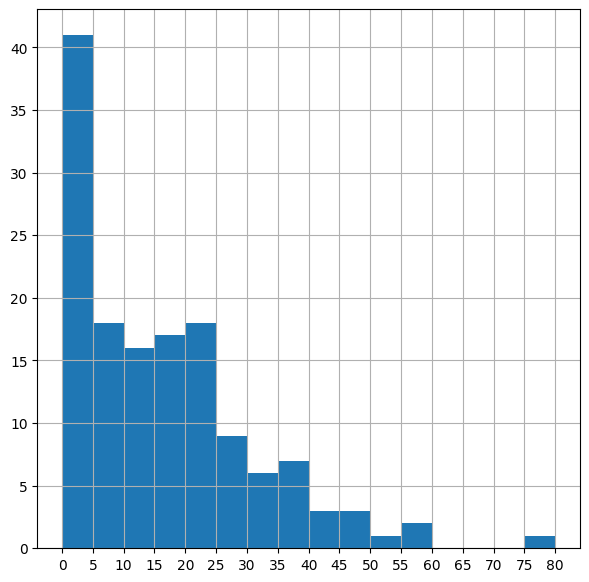

In [211]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.hist(list_count, bins=np.arange(0, np.max(list_count) + 5, 5))
ax.grid()
ax.set_xticks(np.arange(0, np.max(list_count) + 5, 5))
plt.show()

In [181]:
def remove_empty_chunks(document):
    return [chunk for chunk in document if chunk is not None and re.search(r'[a-zA-Z]+', chunk)]

In [262]:
def chunk_by_least_common_delimiter(document, delimiters):
    best_chunking = None
    best_num_chunks = float('inf')
    best_document_chunked = None

    for key, delimiter in delimiters.items():
        document_chunked = re.split(delimiter, document)
        document_chunked = remove_empty_chunks(document_chunked)
        document_chunked_num_chunks = len(document_chunked)

        if (document_chunked_num_chunks > 1) and (document_chunked_num_chunks < best_num_chunks):
            best_num_chunks = document_chunked_num_chunks
            best_document_chunked = document_chunked
            best_chunking = key
    print(best_chunking)
    return best_document_chunked

In [187]:
def chunk_document(document):
    explicit_delimiters = {
        'heading_first_level': rf'\s*#{{1,1}}\s*',
        'headings_second_level:'
        'list': rf'\n\s*#*\s*\d+\.(\d+\.?){{0,{1-1}}}\s+',
    }

    document_chunked = chunk_by_least_common_delimiter(document, explicit_delimiters)

    for chunk in document_chunked:
        token_count = len(tokenizer.tokenize(chunk))
        if token_count > sentence_transformer_max_tokens:
            print(chunk)

In [184]:
explicit_delimiters = {
        'headings': rf'\s*#\s*',
        'list': rf'\n\s*#*\s*\d+\.(\d+\.?){{0,{1-1}}}\s+',
}

In [188]:
documents_chunked = [chunk_document(document) for document in documents]

# Aalto University  

## Aalto University Research Data Management Policy  

The research data management policy aims to make data management easier for the individual researcher. Managing and curating data creates competitive edge, and allocating resources for that is a strategic choice of the university. The purposes of this policy are to (1) encourage to informed decision making in research data management and (2) define the principles used in the opening of publicly funded scientific research data to achieve wide societal impact and the strategic goals of Aalto University.  

The data management policy shall be implemented through conscious and strategic decisions. Open access publishing of research data aims to make research data easily discoverable, assessable, intelligible, usable and interoperable. Where applicable, these requirements can also be applied to data other than open access published research data, and to the software needed to handle the open data. The decisions to 

TypeError: 'NoneType' object is not iterable

In [189]:
documents_chunked[0]

['# Aalto University  \n\n## Aalto University Research Data Management Policy  \n\nThe research data management policy aims to make data management easier for the individual researcher. Managing and curating data creates competitive edge, and allocating resources for that is a strategic choice of the university. The purposes of this policy are to (1) encourage to informed decision making in research data management and (2) define the principles used in the opening of publicly funded scientific research data to achieve wide societal impact and the strategic goals of Aalto University.  \n\nThe data management policy shall be implemented through conscious and strategic decisions. Open access publishing of research data aims to make research data easily discoverable, assessable, intelligible, usable and interoperable. Where applicable, these requirements can also be applied to data other than open access published research data, and to the software needed to handle the open data. The decis

In [136]:
hierarchical_heading_stats = [has_hierarchical_heading(text) for text in documents]

NameError: name 'has_hierarchical_heading' is not defined

In [100]:
np.unique_counts(hierarchical_heading_stats)

UniqueCountsResult(values=array([False,  True]), counts=array([  1, 141]))

In [51]:
def remove_empty_chunks(document):
    return [chunk for chunk in document if (chunk is not None) and (bool(re.search(r'[a-zA-Z]+', chunk)))]

In [52]:
def chunk_document_regex(document, regex_delimiters):
    documents_chunked = []
    for key, value in regex_delimiters.items():
        document_chunked = re.split(value, document)
        document_chunked = remove_empty_chunks(document_chunked)
        documents_chunked.append(document_chunked)

    documents_chunked_len = [len(document_chunked) for document_chunked in documents_chunked]
    max_index = np.argmax(documents_chunked_len)
    max_len = documents_chunked_len[max_index]
    return documents_chunked, max_index, max_len

In [89]:
documents_chunked = []
chunk_history = []

explicit_delimiters = {
        'headings': rf'\s*#{{1,{1}}}\s*',
        'list': rf'\n\s*#*\s*\d+\.(\d+\.?){{0,{1-1}}}\s+',
}

for document in documents:
     document_chunked, max_index, max_len = chunk_document_regex(document, explicit_delimiters)
     my_document_chunked = document_chunked[max_index]
     documents_chunked.append(my_document_chunked)
     my_delimiter = list(explicit_delimiters.keys())[max_index]
     chunk_history.append(my_delimiter)

In [90]:
documents_chunked = flatten(documents_chunked)

In [91]:
documents_chunked

['Aalto University',
 'Aalto University Research Data Management Policy  \n\nThe research data management policy aims to make data management easier for the individual researcher. Managing and curating data creates competitive edge, and allocating resources for that is a strategic choice of the university. The purposes of this policy are to (1) encourage to informed decision making in research data management and (2) define the principles used in the opening of publicly funded scientific research data to achieve wide societal impact and the strategic goals of Aalto University.  \n\nThe data management policy shall be implemented through conscious and strategic decisions. Open access publishing of research data aims to make research data easily discoverable, assessable, intelligible, usable and interoperable. Where applicable, these requirements can also be applied to data other than open access published research data, and to the software needed to handle the open data. The decisions t

In [92]:
len(chunk_history)

142

In [93]:
np.unique_counts(chunk_history)

UniqueCountsResult(values=array(['headings', 'list'], dtype='<U8'), counts=array([82, 60]))

In [57]:
df = pd.DataFrame(data={
    'text': documents_chunked,
    'token_count' : [len(tokenizer.tokenize(chunk)) for chunk in documents_chunked],
})

In [58]:
df

,text,token_count
0,Aalto University,3
1,Aalto University Research Data Management Poli...,659
2,Principles for open access publishing of resea...,22
3,1. Discoverability \n\nThe location of resear...,36
4,2. Accessibility \n\nResearch data and the ne...,230
...,...,...
2469,"FAIR Data\n\nWhere it is lawful to do so, the ...",96
2470,Prifysgol Wrecsam Wrexham University\n\nPublic...,80
2471,Reporting a Data Incident/Breach\n\nThe UK GDP...,125
2472,"Other Polices, Procedures, Legislation\n\nThis...",51


In [59]:
mask = df['token_count'] >= sentence_transformer_max_tokens
df_mask = df[mask]

In [61]:
rest_chunks =df_mask['text'].to_list()

In [62]:
rest_chunks

['Aalto University Research Data Management Policy  \n\nThe research data management policy aims to make data management easier for the individual researcher. Managing and curating data creates competitive edge, and allocating resources for that is a strategic choice of the university. The purposes of this policy are to (1) encourage to informed decision making in research data management and (2) define the principles used in the opening of publicly funded scientific research data to achieve wide societal impact and the strategic goals of Aalto University.  \n\nThe data management policy shall be implemented through conscious and strategic decisions. Open access publishing of research data aims to make research data easily discoverable, assessable, intelligible, usable and interoperable. Where applicable, these requirements can also be applied to data other than open access published research data, and to the software needed to handle the open data. The decisions to publish software, o

In [75]:
documents_chunked = []
chunk_history = []

explicit_delimiters = {
        'headings': rf'\s*#{{1,{1}}}\s*',
        'list': rf'\n\s*#*\s*\d+\.(\d+\.?){{0,{5-1}}}\s+',
}

for chunk in rest_chunks:
     document_chunked, max_index, max_len = chunk_document_regex(document, explicit_delimiters)
     my_document_chunked = document_chunked[max_index]
     documents_chunked.append(my_document_chunked)
     my_delimiter = list(explicit_delimiters.keys())[max_index]
     chunk_history.append(my_delimiter)

In [76]:
len(chunk_history)

98

In [77]:
np.unique_counts(chunk_history)

UniqueCountsResult(values=array(['headings'], dtype='<U8'), counts=array([98]))